In [2]:
library(stringr)
library(ggplot2)
library(dplyr)
library(reshape2)
library(tibble)

options(repr.matrix.max.rows=10, repr.matrix.max.cols=15)

slib = "validationDS"

theme_set(theme_minimal())
theme_update(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
theme_update(text = element_text(size = 17))

#Functions

get_genus <- function(taxon_string){
    if(taxon_string == "") {
        ret = NA } else {
    bacs = str_split(taxon_string, ",")[[1]]
    ret = unlist(unique(lapply(str_split(bacs,"/"),`[[`, 5)))[1]
    if(grepl("acteroides", ret, fixed=TRUE)) ret = "Bacteroides_mix"
        }
    return (ret)
    }

get_phylum <- function(taxon_string){
    if(taxon_string == "") {
        ret = NA } else {
    bacs = str_split(taxon_string, ",")[[1]]
    ret = unlist(unique(lapply(str_split(bacs,"/"),`[[`, 1)))[1]
        }
    return (ret)
    }

convert_samplenames = function(here){
    here %>% substring(3,3) -> plate
    here %>% str_sub(-1,-1) %>% gsub("1","",.) %>% gsub("2",".2",.) -> duplicate
    here %>% gsub("-",".",.) %>% str_sub(5,-2) %>% paste0(.,duplicate,"X19",plate) %>% 
    return
}

In [7]:
# combine all phage annotation data

GPD_anno = read.table("../data/GPD_annotation_pilotphages.csv", sep = ",", header=TRUE, comment.char = "", row.names = 1)
GPD_anno %>% mutate(NorthAmcaFreq = str_count(Continents_detected, "North America")) %>% 
select(Source, GPD_VC, Size, Predicted_phage_taxon, checkV_prophage, Novel, NorthAmcaFreq, Host_range_taxon) %>% rownames_to_column("taxon_id") -> GPD_anno

GPD_anno %>% select(taxon_id,GPD_VC) %>% unique() %>%
select(GPD_VC) %>% table() %>% as.data.frame() %>% rename(GPD_VC = ".") %>% 
rename(cluster_phages = "Freq") %>% subset(cluster_phages==1) %>% pull(GPD_VC) -> singleclusters

GPD_anno %>% mutate(GPD_VC = ifelse(GPD_VC %in% singleclusters, NA, GPD_VC)) %>%
mutate(GPD_VC = as.factor(GPD_VC)) %>%
mutate(Host_Genus = sapply(Host_range_taxon,get_genus)) %>% mutate(Host_Genus = as.factor(Host_Genus)) %>%
mutate(Host_Phylum = sapply(Host_range_taxon,get_phylum)) %>% mutate(Host_Phylum = as.factor(Host_Phylum)) %>%
mutate(Predicted_phage_taxon = droplevels(Predicted_phage_taxon,"")) -> 
GPD_anno

blast_anno = read.table("../data/pilotphages_blast_annotation.csv", sep = ",", header=TRUE, row.names = 1) 
paste("Blast", colnames(blast_anno), sep = "_") -> colnames(blast_anno)
blast_anno %>% rownames_to_column("taxon_id") %>% merge(GPD_anno) -> GPD_anno

anno_pep = read.table("../data/DolphynLa_001_Universal.tsv", header = TRUE, sep = "\t", row.names = 2)
anno_pep = anno_pep[anno_pep$sublibrary != "validationDS",]
anno_pep %>% 
    select(c("sublibrary","pro_len", "pro_id", "pep_id","pos_start", "pos_end", "taxon_id", "pro_id_all")) %>% 
    mutate(across(where(is.factor), as.character)) -> anno_pep

anno_pep %>% select(pep_id,pro_id_all) %>% distinct() %>% 
    mutate(pro_id_all = gsub("[{} ]","",pro_id_all)) %>%
    mutate(pro_id_all = strsplit(pro_id_all,",")) -> peptide_clusters_map
p = peptide_clusters_map$pro_id_all
names(p) <- peptide_clusters_map$pep_id
protein_clusters = stack(p)
anno_pep %>% merge(protein_clusters, by.x = 'pep_id', by.y = "ind", all = TRUE) %>% 
    rename(pro_id_representative = pro_id) %>% rename(pro_id = values) %>% select(-pro_id_all) -> anno_pep
anno_pep %>% select(-taxon_id) %>%  mutate(taxon_id = sub("_[^_]+$", "", pro_id)) -> anno_pep

anno_pep %>% group_by(taxon_id, sublibrary) %>% 
mutate(prot_per_phage= length(unique(pro_id))) %>% 
mutate(peps_per_phage= length(unique(pep_id))) %>%
distinct(pro_id, pro_len, prot_per_phage, peps_per_phage) %>% mutate(phage_len = sum(pro_len)) %>%
ungroup %>%
distinct(taxon_id, sublibrary, prot_per_phage, peps_per_phage, phage_len) %>%
merge(GPD_anno) %>% 
mutate(library = gsub(sublibrary,pattern = "dolphin", replacement= "dolphyn")) %>%
select(-sublibrary) -> phage_meta

phage_meta %>% mutate(bin_myoviridae = as.factor(ifelse(Predicted_phage_taxon %in% "Myoviridae", "True", "False"))) %>%
mutate(bin_Escherichia = as.factor(ifelse(Host_Genus %in% "Escherichia", "True", "False"))) -> phage_meta

#some solumns are different in the different libraries
rbind(phage_meta, phage_meta %>% subset(library == "pepsyn") %>% mutate(library = "all")) -> phage_meta
rbind(phage_meta, phage_meta %>% mutate(library = paste0(library,"_7"))) -> phage_meta

In [10]:
meta = read.table("../data/Helmsley_VRC_metadata_121721.csv", header = TRUE, sep = ",", row.names = 1)
meta[,c("Age","Sex","Race")] %>% rownames_to_column("sample_id") -> meta

filenames_pre = "20230123 - "
filenames_post = " - max 7 iterations"

phar_dolphyn_194_7 = readRDS(paste0("../data/",filenames_pre , "phip194_PhARscores_dolphyn" , filenames_post , ".rds"))
phar_dolphyn_195_7 = readRDS(paste0("../data/" , filenames_pre , "phip195_PhARscores_dolphyn" , filenames_post , ".rds"))
phar = rbind(phar_dolphyn_194_7,phar_dolphyn_195_7) %>% mutate(library = "dolphyn_7") 

phar_pepsyn_194_7 = readRDS(paste0("../data/" , filenames_pre , "phip194_PhARscores_pepsyn" , filenames_post , ".rds"))
phar_pepsyn_195_7 = readRDS(paste0("../data/" , filenames_pre , "phip195_PhARscores_pepsyn" , filenames_post , ".rds"))
rbind(phar_pepsyn_194_7,phar_pepsyn_195_7) %>% mutate(library = "pepsyn_7") %>%
rbind(phar) -> phar

phar %>%
    mutate(hm_value = ifelse(p_val > 2, vir_score, NA)) %>%
    mutate(agg_score = p_val * vir_score) %>%
    mutate(cut_score = ifelse(p_val > 2, vir_score, 0)) %>%
    mutate(vir_score_cut = case_when(
         vir_score > 1 ~ 1,
         vir_score < -1 ~ -1,
         TRUE ~ vir_score)) %>%
    mutate(vir_score_bin = ifelse(vir_score > 1, 1, 0)) %>%
    mutate(sample_id = gsub(sample_id,pattern = "-20A20G-", replacement= "")) %>%
    mutate(sample_id = gsub(sample_id,pattern = "-VRC-Control-VRC", replacement= "")) %>%
    mutate(plate = as.factor(substr(sample_id,1,3))) %>%
    mutate(sample = sample_id) %>%
    mutate(sample_id = gsub(str_sub(sample_id,5,-2),pattern = "-", replacement= ".")) -> 
phar

phar %>% merge(meta, all.x = TRUE) %>% merge(phage_meta, all.x = TRUE) %>% 
mutate(p_val_re = 10^-p_val) -> phar

In [13]:
anno_pep = read.table("../data/DolphynLa_001_Universal.tsv", header = TRUE, sep = "\t", row.names = 2)
anno_pep = anno_pep[anno_pep$sublibrary != "validationDS",]
anno_pep %>% 
    select(c("sublibrary","pro_len", "pro_id", "pep_id","pos_start", "pos_end", "taxon_id", "pro_id_all")) %>% 
    mutate(across(where(is.factor), as.character)) -> anno_pep
# Hit Foldchange Data
files <- list.files("../data/", pattern = "\\_DolphynLa_001_Hits_foldchange.tsv$",  recursive = TRUE)
fc <-  read.table(paste0("../data/",files[1]), header=TRUE, row.names = 1)
fc <- cbind(fc, read.table(paste0("../data/",files[2]), header=TRUE, row.names = 1))  
fc %>% select(!contains("BEADS_ONLY")) -> fc
fc = fc[rownames(anno_pep),]
lfc_org = log(fc)

# cleaning up sample names
anno_samples = data.frame(org = colnames(lfc_org))
anno_samples = cbind(anno_samples, str_split_fixed(anno_samples$org, "\\.",4))
anno_samples$sampleID = anno_samples$`4`
anno_samples %>% mutate(sampleID = gsub("Pre.Therapy_.", "", sampleID)) %>% mutate(sampleID = gsub(".20A20G.1", "", sampleID)) %>% 
                mutate(sampleID = gsub(".20A20G", "", sampleID)) %>% mutate(sampleID = gsub("VRC.", "", sampleID)) %>% 
                mutate(sampleID = gsub("IBD.Control.", "", sampleID)) %>% mutate(sampleID = gsub("_", "", sampleID)) -> anno_samples
rownames(anno_samples) = paste0(anno_samples$sampleID,anno_samples$`1`)
colnames(anno_samples) = c("original", "plate", "dataset", "group", "description", "sampleID")
colnames(lfc_org) = rownames(anno_samples)

In [14]:
phar %>% subset(library == "pepsyn_7") %>% subset(! taxon_id %in% c("uvig_250342","uvig_358797","uvig_205260")) %>% 
group_by(taxon_id) %>% 
summarise_at(vars(vir_score), funs(mean = mean, sum = sum, max = max)) %>%
arrange(desc(max)) %>% select(taxon_id) %>% unique %>% head(4) %>% unlist -> top_score_phage

phar %>% subset(library == "pepsyn_7") %>% 
group_by(sample) %>% 
summarise_at(vars(vir_score), funs(mean = mean, sum = sum, max = max)) %>%
arrange(desc(max)) %>% head(5) %>% select(sample) %>% unique %>% 
sapply(convert_samplenames) %>% as.list %>% unlist -> top_score_sample

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


In [15]:
top_score_phage

taxon_id1     taxon_id2     taxon_id3     taxon_id4 
"uvig_395307" "uvig_356750" "uvig_396772" "uvig_356226"

In [16]:
ap = read.table("../data/DolphynLa_001_Universal.tsv", header = TRUE, sep = "\t", row.names = 2, stringsAsFactors=FALSE) 

In [17]:
ap %>% 
select(pep_id, sublibrary,pep_aa) %>% subset(sublibrary == "dolphin") %>%
mutate(pep1 = str_split(pep_aa, "GGGGS", simplify=TRUE)[,1])%>%
mutate(pep2 = str_split(pep_aa, "GGGGS", simplify=TRUE)[,2])%>%
mutate(pep3 = gsub("\\*","",str_split(pep_aa, "GGGGS", simplify=TRUE)[,3],)) %>%
melt(id.vars = c("pep_id","sublibrary","pep_aa"), value.name = "sub_aa", variable.name = "pep_no") %>%
merge(ap %>% subset(sublibrary == "dolphinepitopes") %>% mutate(pep_aa = str_sub(pep_aa,6,20)) %>% select(pep_id,pep_aa),
      by.x="sub_aa", by.y = "pep_aa") -> dol_epi_map

In [18]:
rbind(dol_epi_map %>% select(pep_id.x) %>% unique() %>% rename(triplet_id = pep_id.x) %>% mutate(pep_id = triplet_id) %>% mutate(pep_no = "triplet"),
      dol_epi_map %>% select(pep_id.y, pep_id.x, pep_no) %>% rename(pep_id = pep_id.y) %>% rename(triplet_id = pep_id.x)) -> dol_epi_map

In [19]:
samples_to_check = top_score_sample[1:4]
lfc_org %>% select(all_of(samples_to_check)) %>% rownames_to_column("pep_id2") %>% 
melt(id.vars = "pep_id2", value.name="lfc", variable.name = "sample") -> tdf
anno_pep %>% select(c("sublibrary", "pro_id", "pep_id", "taxon_id")) %>% 
subset(sublibrary != "pepsyn") %>% 
#subset(taxon_id == top_score_phage[1]) %>% 
rownames_to_column("pep_id2") %>% 
merge(tdf) %>% mutate(across(where(is.factor), as.character)) -> tdf 

In [20]:
merge(dol_epi_map,tdf) %>% mutate(tripletSample = paste(triplet_id,sample)) %>% 
select(taxon_id,pro_id,lfc,pep_no,tripletSample) %>%
mutate(lfc_bin = lfc >0) %>%
group_by(tripletSample) %>% summarise_at(vars(lfc_bin), funs(sum=sum, n= n())) %>%
subset(sum>1) %>% select(tripletSample) %>% unlist() -> positive_triplets

merge(dol_epi_map,tdf) %>% mutate(tripletSample = paste(triplet_id,sample)) %>% 
select(taxon_id,pro_id,lfc,pep_no,triplet_id,tripletSample, sample) %>%
subset(tripletSample %in% positive_triplets) %>% 
mutate(lfc_bin = lfc >0) %>%
arrange(desc(lfc_bin), desc(lfc)) %>% 
mutate(triplet_id = factor(triplet_id, levels = unique(triplet_id))) -> temp

null device 
          1

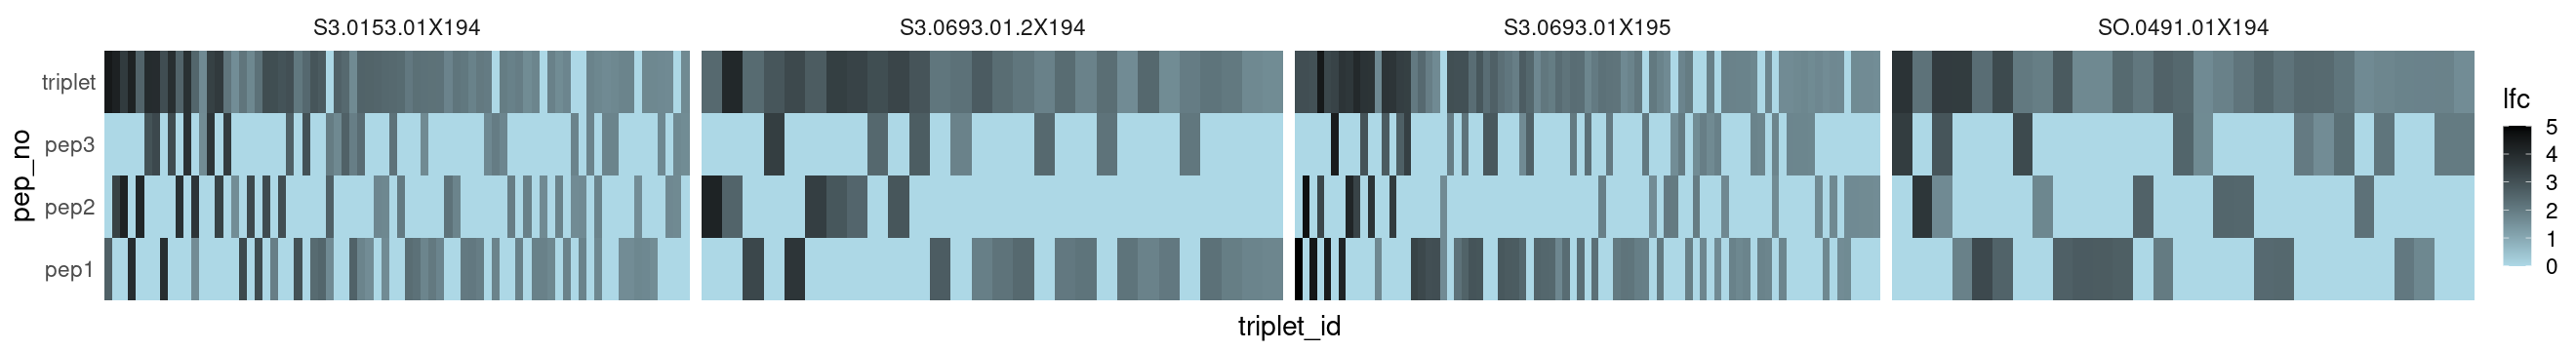

In [21]:
options(repr.plot.width=22, repr.plot.height=3)

temp %>%
ggplot(aes(triplet_id,pep_no)) + geom_tile(aes(fill = lfc)) + scale_fill_gradient(low = "lightblue", high = "black") + 
theme(axis.text.x=element_blank(), panel.grid.major.x = element_blank(), panel.grid.major.y = element_blank()) +
facet_grid(.~sample, scales= "free")

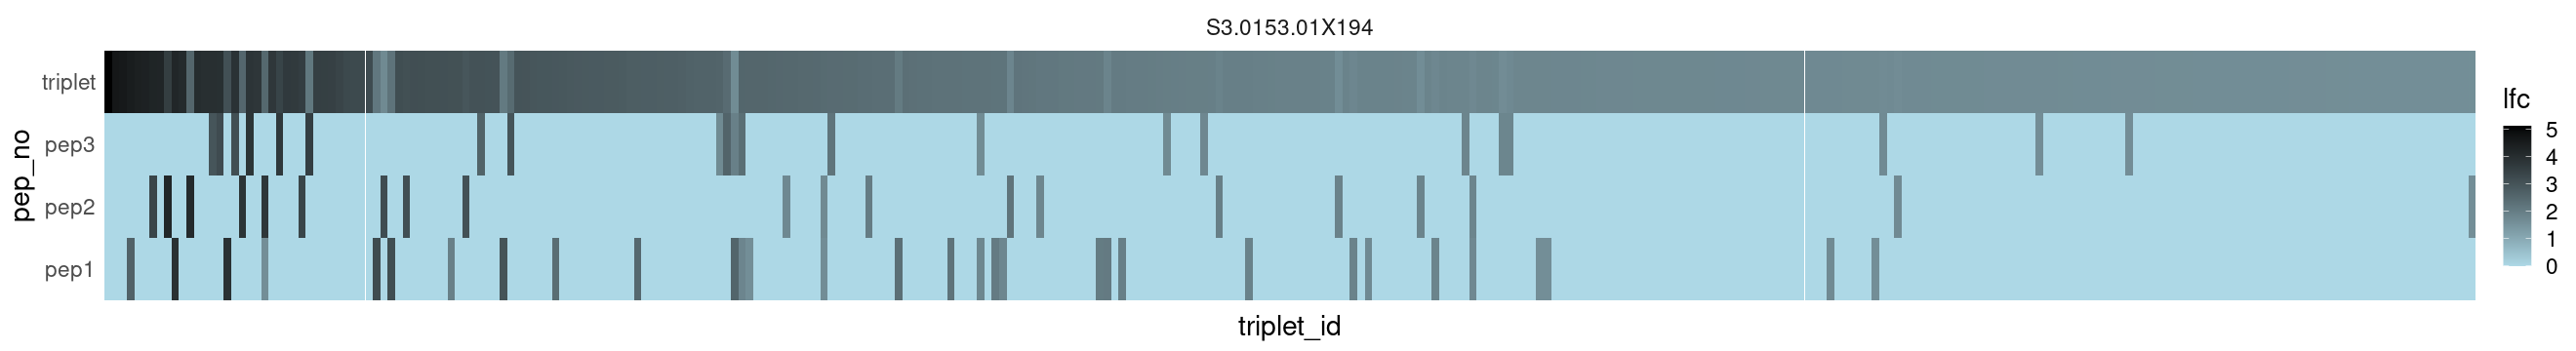

In [14]:
options(repr.plot.width=22, repr.plot.height=3)

merge(dol_epi_map,tdf) %>% mutate(tripletSample = paste(triplet_id,sample)) %>% 
select(taxon_id,pro_id,lfc,pep_no,tripletSample) %>%
subset(pep_no == "triplet") %>% subset(lfc > 0) %>% select(tripletSample) %>% unlist() -> non_zero_triplets


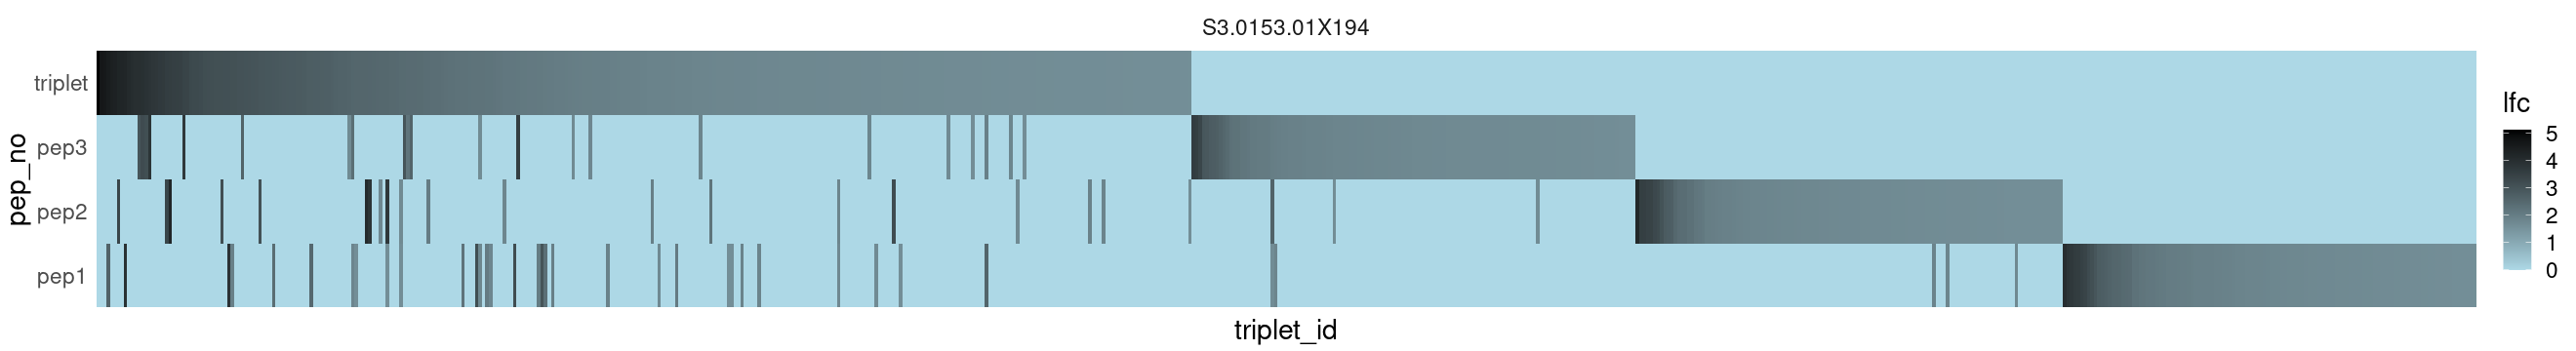

In [15]:
options(repr.plot.width=22, repr.plot.height=3)

merge(dol_epi_map,tdf) %>% 
subset(sample == "S3.0153.01X194")%>% mutate(tripletSample = paste(triplet_id,sample)) %>% 
select(taxon_id,pro_id,lfc,pep_no,tripletSample) %>%
mutate(lfc_bin = lfc >0) %>%
group_by(tripletSample) %>% summarise_at(vars(lfc_bin), funs(sum=sum, n= n())) %>%
subset(sum>0) %>% select(tripletSample) %>% unlist() -> positive_triplets


In [22]:
lfc_org %>% rownames_to_column("pep_id2") %>%
merge(anno_pep %>% select(c("sublibrary", "pro_id", "pep_id", "taxon_id"))%>% rownames_to_column("pep_id2")) %>%
subset(sublibrary != "pepsyn") %>% 
merge(dol_epi_map) %>% 
melt(id.vars = c("sublibrary", "pro_id", "pep_id", "taxon_id","pep_id2","triplet_id","pep_no"), value.name="lfc", variable.name = "sample") %>% 
mutate(tripletSample = paste(triplet_id,sample)) -> tdf_all

In [26]:
tdf_all

sublibrary,pro_id,pep_id,taxon_id,pep_id2,triplet_id,pep_no,sample,lfc,tripletSample
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>
dolphin,uvig_355478_29,dolphin_1001031390910937997,uvig_355478,DolphynLa_001_ATGGGCCTCGAACTGGTTAAGATGTTGCTCGACGTGAAAACTAAAGGTGG,dolphin_1001031390910937997,triplet,SMART003X194,0,dolphin_1001031390910937997 SMART003X194
dolphin,uvig_355286_47,dolphin_1001974258484100911,uvig_355286,DolphynLa_001_ACCGCTAAACAGCCGCAGTATGCAGCACTGTTGACCCAATATAAAGGTGG,dolphin_1001974258484100911,triplet,SMART003X194,0,dolphin_1001974258484100911 SMART003X194
dolphin,uvig_356033_7,dolphin_1003182168634213578,uvig_356033,DolphynLa_001_AAGTTGTCTACTGCAAAGCTTAAGCCGCTTAGGTACCTGAAATACGGTGG,dolphin_1003182168634213578,triplet,SMART003X194,0,dolphin_1003182168634213578 SMART003X194
dolphin,uvig_355286_8,dolphin_1003281628142369923,uvig_355286,DolphynLa_001_AAAAATGGTGAATTCCTGGAATGGGCCGAGTATAGAGGATGGCGCGGCGG,dolphin_1003281628142369923,triplet,SMART003X194,0,dolphin_1003281628142369923 SMART003X194
dolphin,uvig_356033_28,dolphin_1003390492466174482,uvig_356033,DolphynLa_001_ACCGGCGACTTTCGCGGTGCATGGGATGGCATTAAGTCAATTTTCGGCGG,dolphin_1003390492466174482,triplet,SMART003X194,0,dolphin_1003390492466174482 SMART003X194
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
dolphinepitopes,uvig_355854_33,dolphinepitopes_997758404587082812,uvig_355854,DolphynLa_001_GGGGGCGGTGGATCAACCGCGTCAAAGGAACAGTTAGCAGCCTGGCACAA,dolphin_5512961784471541455,pep3,SMART397X195,0,dolphin_5512961784471541455 SMART397X195
dolphinepitopes,uvig_356792_41,dolphinepitopes_998209062551859471,uvig_356792,DolphynLa_001_GGTGGTGGTGGTTCGTTATCAATGTCACCTAAAGAGACAAATTATCGCGC,dolphin_362180758767367399,pep2,SMART397X195,0,dolphin_362180758767367399 SMART397X195
dolphinepitopes,ivig_2475_39,dolphinepitopes_998282101512657035,ivig_2475,DolphynLa_001_GGCGGCGGAGGTTCAGCAGAGTGGTTAGAAGAACCGAAGCGTATTCCGGG,dolphin_5945177458264591888,pep2,SMART397X195,0,dolphin_5945177458264591888 SMART397X195


In [57]:
options(repr.plot.width=5, repr.plot.height=4)

tdf_all %>% subset(lfc>0) %>% arrange(desc(lfc)) %>% group_by(pep_no) %>% mutate(order = row_number()) %>%
subset(order < 3000) %>%

ggplot(aes(order, lfc, color = pep_no)) + geom_line(size = 1)

png 
  2

In [36]:
dol_epi_map

,triplet_id,pep_id,pep_no
,<chr>,<chr>,<chr>
1,dolphin_6504870519776975373,dolphin_6504870519776975373,triplet
2,dolphin_7355551626334405622,dolphin_7355551626334405622,triplet
3,dolphin_8004269479798127467,dolphin_8004269479798127467,triplet
4,dolphin_5391934245698640426,dolphin_5391934245698640426,triplet
5,dolphin_3708885669394750382,dolphin_3708885669394750382,triplet
⋮,⋮,⋮,⋮
15789,dolphin_3608753923611404341,dolphinepitopes_6781668877605090241,pep2
15790,dolphin_2966580571493938827,dolphinepitopes_2822159737553260263,pep2
15791,dolphin_7542324584028422118,dolphinepitopes_7314170211180655409,pep1
